INTERMEDIATE LEVEL - TASK 2: MULTIPLE REGRESSION MODEL

📥 CARGANDO DATASET CON FEATURES ENGINEERED...
✓ Dataset reducido con mejores características cargado
📊 Dataset cargado: (3000888, 35)
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

🔍 DIAGNÓSTICO DEL DATASET
📊 Forma del dataset: (3000888, 35)
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

📋 COLUMNAS DISPONIBLES:
  - date: datetime64[ns] (nulos: 0)
  - store_nbr: int64 (nulos: 0)
  - family: object (nulos: 0)
  - sales: float64 (nulos: 0)
  - onpromotion: int64 (nulos: 0)
  - sales_rolling_ema_7: float64 (nulos: 0)
  - sales_rolling_ema_14: float64 (nulos: 0)
  - sales_rolling_mean_7: float64 (nulos: 0)
  - sales_rolling_ema_30: float64 (nulos: 0)
  - sales_rolling_mean_14: float64 (nulos: 0)
  - sales_rolling_mean_30: float64 (nulos: 0)
  - sales_lag_7: float64 (nulos: 12474)
  - sales_rolling_ema_60: float64 (nulos: 0)
  - sales_rolling_ema_90: float64 (nulos: 0)
  - sales_rolling_mean_60: float64 (

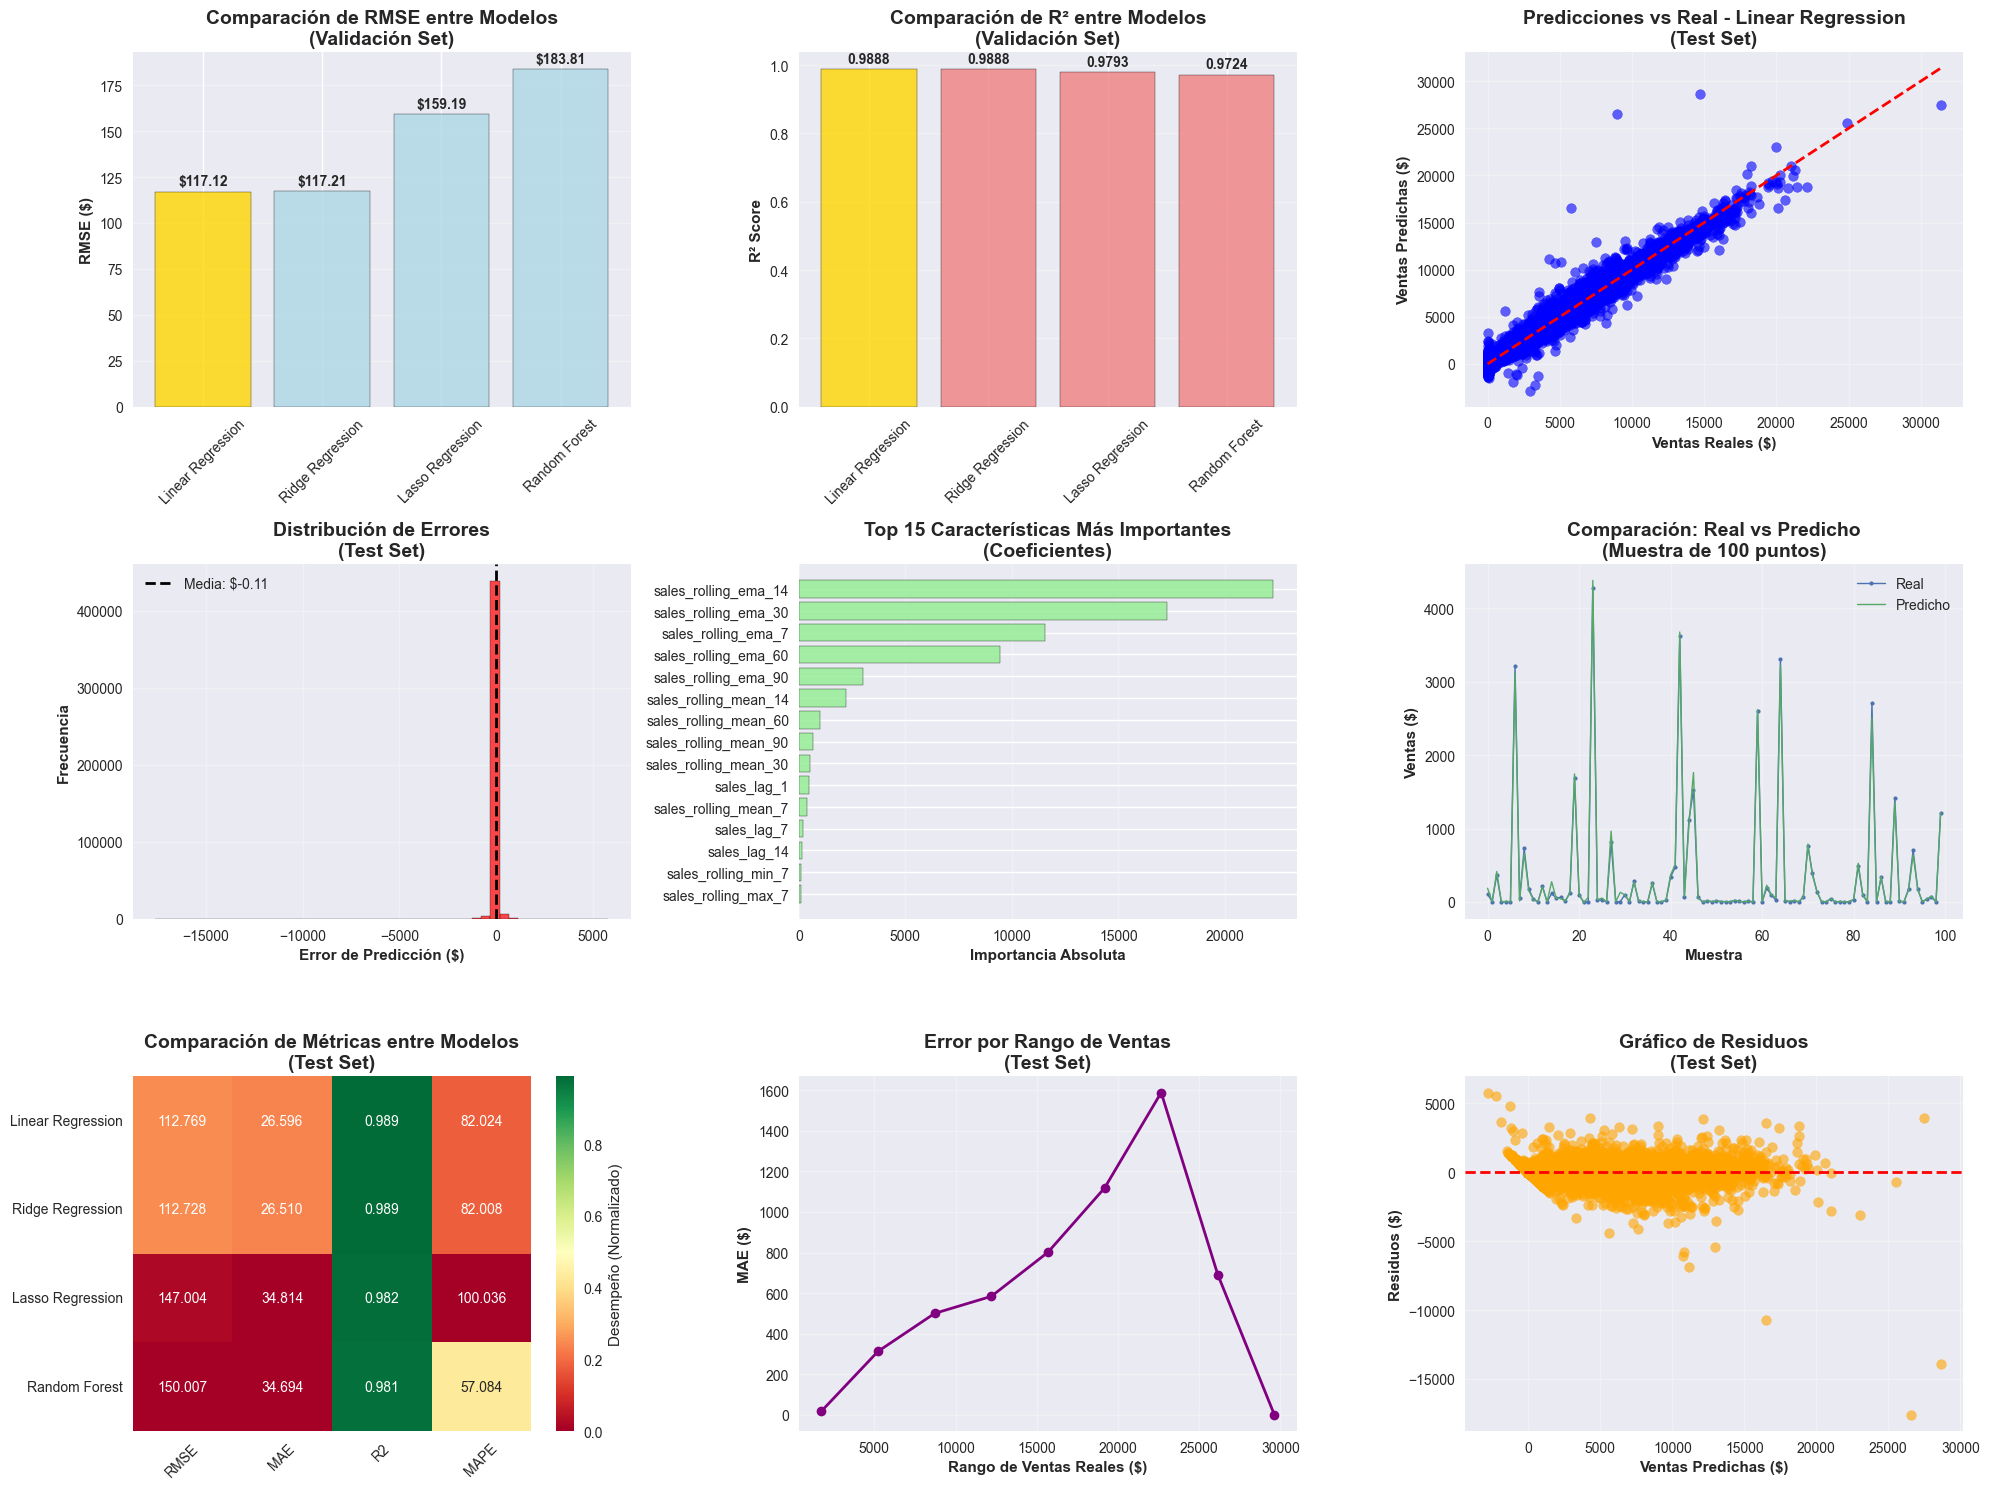


💾 GUARDANDO MODELO Y MÉTRICAS
✅ Mejor modelo guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\best_multiple_regression_model.pkl
✅ Scaler guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\multiple_regression_scaler.pkl
✅ Características seleccionadas guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\selected_features.pkl
✅ Métricas guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\multiple_regression_metrics.csv

📊 RESUMEN EJECUTIVO - REGRESIÓN MÚLTIPLE

🎯 RESULTADOS PRINCIPALES:
   • Mejor modelo: Linear Regression
   • Exactitud (R² Test): 0.9893
   • Error (RMSE Test): $112.77
   • Error porcentual (MAPE Test): 82.02%

🔍 INTERPRETACIÓN DEL MODELO:
   • Rendimiento: EXCELENTE
   • El modelo explica el 98.9% de la variabilidad en las ventas

📈 CARACTERÍSTICAS MÁS IMPORTANTES:
   1. sales_rolling_ema_14: DISMINUYE ventas (coef: -22265.268)
   2. sales_rolling_ema_30: AUMENTA ventas (coef: 17

In [1]:
# 1️⃣ Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer

print("=" * 70)
print("INTERMEDIATE LEVEL - TASK 2: MULTIPLE REGRESSION MODEL")
print("=" * 70)

# 2️⃣ Cargar dataset con features
print("\n📥 CARGANDO DATASET CON FEATURES ENGINEERED...")

# Configurar rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
features_path = os.path.join(base_dir, "features")
models_path = os.path.join(base_dir, "models")
os.makedirs(models_path, exist_ok=True)

# Cargar dataset de características
try:
    # Primero intentar con el dataset reducido (mejores características)
    reduced_path = os.path.join(features_path, 'sales_features_reduced.csv')
    df = pd.read_csv(reduced_path, parse_dates=['date'])
    print("✓ Dataset reducido con mejores características cargado")
except FileNotFoundError:
    try:
        # Si no existe, cargar el dataset completo
        feature_engineered_path = os.path.join(features_path, 'sales_feature_engineered.csv')
        df = pd.read_csv(feature_engineered_path, parse_dates=['date'])
        print("✓ Dataset completo con características engineered cargado")
    except FileNotFoundError:
        print("❌ No se encontraron datasets de características. Ejecuta primero Task 1: Feature Engineering")
        exit()

print(f"📊 Dataset cargado: {df.shape}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# 🔍 DIAGNÓSTICO DEL DATASET
print("\n" + "=" * 70)
print("🔍 DIAGNÓSTICO DEL DATASET")
print("=" * 70)

print(f"📊 Forma del dataset: {df.shape}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# Mostrar todas las columnas y sus tipos
print("\n📋 COLUMNAS DISPONIBLES:")
for col in df.columns:
    print(f"  - {col}: {df[col].dtype} (nulos: {df[col].isnull().sum()})")

# 3️⃣ SOLUCIÓN ROBUSTA PARA SELECCIÓN DE CARACTERÍSTICAS
print("\n" + "=" * 70)
print("🎯 SELECCIÓN INTELIGENTE DE CARACTERÍSTICAS")
print("=" * 70)

# Columnas a excluir siempre
exclude_cols = ['date', 'store_nbr', 'family', 'sales', 'id']

# Estrategia: usar características del dataset reducido si está disponible
if os.path.exists(os.path.join(features_path, 'sales_features_reduced.csv')):
    print("• Usando características pre-seleccionadas del dataset reducido")
    feature_columns = [col for col in df.columns if col not in exclude_cols]
else:
    print("• Seleccionando mejores características del dataset engineered")
    
    # Priorizar características basadas en naming patterns comunes
    priority_patterns = [
        'lag_', 'rolling_', 'avg_', 'mean_', 'std_', 'trend_',
        'yearly_', 'monthly_', 'weekly_', 'seasonal_',
        'onpromotion', 'dcoilwtico', 'transactions'
    ]
    
    feature_columns = []
    
    # Buscar características por patrones prioritarios
    for pattern in priority_patterns:
        pattern_cols = [col for col in df.columns if pattern in col and col not in exclude_cols]
        feature_columns.extend(pattern_cols)
        if pattern_cols:
            print(f"  ✓ Encontradas {len(pattern_cols)} características con patrón '{pattern}'")
    
    # Si no encontramos suficientes, usar todas las numéricas
    if len(feature_columns) < 5:
        print("• Pocas características por patrón. Usando todas las numéricas...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        additional_cols = [col for col in numeric_cols if col not in exclude_cols and col not in feature_columns]
        feature_columns.extend(additional_cols)
        print(f"  ✓ Añadidas {len(additional_cols)} características numéricas")

# Eliminar duplicados
feature_columns = list(set(feature_columns))

print(f"\n✅ CARACTERÍSTICAS SELECCIONADAS: {len(feature_columns)}")
for i, col in enumerate(feature_columns[:20], 1):  # Mostrar máximo 20
    print(f"  {i:2d}. {col}")

if len(feature_columns) > 20:
    print(f"  ... y {len(feature_columns) - 20} más")

# VERIFICACIÓN CRÍTICA
if len(feature_columns) == 0:
    print("\n❌ ALERTA: No se encontraron características. Creando características básicas...")
    
    # Crear características temporales básicas
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month  
    df['year'] = df['date'].dt.year
    df['day_of_month'] = df['date'].dt.day
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
    df['quarter'] = df['date'].dt.quarter
    
    feature_columns = ['day_of_week', 'month', 'year', 'day_of_month', 'is_weekend', 'quarter']
    
    # Buscar cualquier otra columna numérica
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    additional_cols = [col for col in numeric_cols if col not in ['sales'] and col not in feature_columns]
    feature_columns.extend(additional_cols[:10])  # Máximo 10 adicionales

# Manejo de valores nulos
print("\n🔍 MANEJO DE VALORES NULOS...")
null_counts = df[feature_columns].isnull().sum()
total_nulls = null_counts.sum()

if total_nulls > 0:
    print(f"• Se encontraron {total_nulls} valores nulos en total")
    
    # Estrategia por columna
    columns_to_remove = []
    for col in feature_columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            null_percentage = (null_count / len(df)) * 100
            print(f"  - {col}: {null_count} nulos ({null_percentage:.2f}%)")
            
            if null_percentage > 50:  # Eliminar columnas con >50% nulos
                print(f"    ✗ Eliminando {col} (>50% nulos)")
                columns_to_remove.append(col)
            else:
                # Llenar con mediana para numéricas
                if df[col].dtype in [np.number]:
                    fill_value = df[col].median()
                    df[col].fillna(fill_value, inplace=True)
                    print(f"    ✓ Llenado con mediana: {fill_value}")
    
    # Eliminar columnas problemáticas
    feature_columns = [col for col in feature_columns if col not in columns_to_remove]
else:
    print("✓ No hay valores nulos en las características seleccionadas")

# VERIFICACIÓN FINAL
if len(feature_columns) == 0:
    raise ValueError("❌ ERROR CRÍTICO: No hay características disponibles después del procesamiento.")

print(f"\n🎯 CARACTERÍSTICAS FINALES: {len(feature_columns)}")

# Preparar datos para modelado
X = df[feature_columns]
y = df['sales']

# 4️⃣ SELECCIÓN POR CORRELACIÓN (OPCIONAL)
print("\n" + "=" * 70)
print("📊 FILTRADO POR CORRELACIÓN")
print("=" * 70)

# Calcular correlaciones solo si tenemos muchas características
if len(feature_columns) > 15:
    print("• Calculando correlaciones para seleccionar mejores características...")
    correlations = {}
    
    for col in feature_columns:
        try:
            # Calcular correlación ignorando nulos
            valid_data = df[[col, 'sales']].dropna()
            if len(valid_data) > 10:  # Mínimo 10 puntos válidos
                corr = np.corrcoef(valid_data[col], valid_data['sales'])[0, 1]
                if not np.isnan(corr):
                    correlations[col] = abs(corr)
        except:
            continue
    
    if correlations:
        # Seleccionar top características
        n_features = min(20, len(correlations))
        top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:n_features]
        selected_features = [feature for feature, corr in top_features]
        
        print(f"• Seleccionadas {len(selected_features)} características por correlación")
        print("🏆 TOP 10 CARACTERÍSTICAS MÁS CORRELACIONADAS:")
        for i, (feature, corr) in enumerate(top_features[:10], 1):
            print(f"  {i:2d}. {feature:<30}: {corr:.4f}")
    else:
        print("• No se pudieron calcular correlaciones. Usando todas las características.")
        selected_features = feature_columns
else:
    print("• Pocas características. Usando todas sin filtrado por correlación.")
    selected_features = feature_columns

# VERIFICACIÓN FINAL
print(f"\n✅ CARACTERÍSTICAS PARA MODELADO: {len(selected_features)}")
X_selected = X[selected_features]

print(f"📊 X_selected shape: {X_selected.shape}")
print(f"🎯 y shape: {y.shape}")

# 4️⃣ Dividir datos
print("\n" + "=" * 70)
print("📊 DIVISIÓN DE DATOS")
print("=" * 70)

# VERIFICACIÓN ANTES DE LA DIVISIÓN
if X_selected.shape[1] == 0:
    print("❌ ERROR: No hay características para dividir. Creando características de emergencia...")
    # Crear características mínimas
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    selected_features = ['day_of_week', 'month']
    X_selected = df[selected_features]

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.15, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, shuffle=True  # 0.176 * 0.85 ≈ 0.15
)

print(f"✅ División completada:")
print(f"  • Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Validación: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  • Prueba: {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# VERIFICACIÓN ANTES DEL ESCALADO
print(f"\n🔍 VERIFICACIÓN FINAL ANTES DEL ESCALADO:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • X_train columnas: {X_train.columns.tolist()}")
print(f"  • ¿X_train vacío?: {X_train.empty}")

# 🔧 CORRECCIÓN: Manejar NaN después de la división
print("\n🔍 VERIFICANDO Y ELIMINANDO NaN...")
print(f"NaN en X_train: {X_train.isnull().sum().sum()}")
print(f"NaN en X_val: {X_val.isnull().sum().sum()}")
print(f"NaN en X_test: {X_test.isnull().sum().sum()}")

# Llenar cualquier NaN restante con la mediana
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())  # Usar medianas del training set
X_test = X_test.fillna(X_train.median())

print("✓ NaN eliminados de los datasets")

# Escalar características
print("\n⚖️ ESCALANDO CARACTERÍSTICAS...")
scaler = StandardScaler()

# Asegurarnos de que no hay NaN antes de escalar
if np.isnan(X_train.values).any() or np.isnan(X_val.values).any() or np.isnan(X_test.values).any():
    print("❌ Aún hay NaN después de la limpieza. Usando SimpleImputer...")
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
else:
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

# Verificar que no hay NaN después del escalado
print(f"✅ Verificación post-escalado:")
print(f"  • NaN en X_train_scaled: {np.isnan(X_train_scaled).any()}")
print(f"  • NaN en X_val_scaled: {np.isnan(X_val_scaled).any()}")
print(f"  • NaN en X_test_scaled: {np.isnan(X_test_scaled).any()}")

# Si aún hay NaN, usar una estrategia más agresiva
if np.isnan(X_train_scaled).any() or np.isnan(X_val_scaled).any() or np.isnan(X_test_scaled).any():
    print("⚠️  Eliminando NaN residuales con np.nan_to_num...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
    X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

print("✓ Características escaladas exitosamente!")
print(f"  • X_train_scaled shape: {X_train_scaled.shape}")

# 5️⃣ Entrenar modelo
print("\n" + "=" * 70)
print("🤖 ENTRENANDO MODELOS DE REGRESIÓN MÚLTIPLE")
print("=" * 70)

# Diccionario para almacenar modelos y resultados
models = {}
results = {}

# Modelo 1: Linear Regression (Regresión Lineal Múltiple)
print("📈 Entrenando Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr_model
print("✓ Linear Regression entrenado")

# Modelo 2: Ridge Regression
print("🏔️ Entrenando Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
models['Ridge Regression'] = ridge_model
print("✓ Ridge Regression entrenado")

# Modelo 3: Lasso Regression
print("🎯 Entrenando Lasso Regression...")
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
models['Lasso Regression'] = lasso_model
print("✓ Lasso Regression entrenado")

# Modelo 4: Random Forest (para comparación)
print("🌲 Entrenando Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
print("✓ Random Forest entrenado")

print(f"✅ {len(models)} modelos entrenados exitosamente")

# 6️⃣ Evaluar modelo
print("\n" + "=" * 70)
print("📊 EVALUACIÓN DE MODELOS")
print("=" * 70)

def evaluate_model(model, X, y, dataset_name):
    """Evaluar modelo y retornar métricas completas"""
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    # Error porcentual absoluto medio
    mape = np.mean(np.abs((y - y_pred) / np.where(y == 0, 1, y))) * 100
    
    # Porcentaje dentro de ±10%
    within_10_percent = (np.abs((y - y_pred) / np.where(y == 0, 1, y)) <= 0.1).mean() * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Within_10_Percent': within_10_percent,
        'Predictions': y_pred
    }

# Evaluar todos los modelos en train, validation y test
datasets = {
    'Train': (X_train_scaled, y_train),
    'Validation': (X_val_scaled, y_val),
    'Test': (X_test_scaled, y_test)
}

for model_name, model in models.items():
    print(f"\n📊 EVALUANDO {model_name.upper()}:")
    print("-" * 40)
    
    model_results = {}
    for dataset_name, (X_data, y_data) in datasets.items():
        metrics = evaluate_model(model, X_data, y_data, dataset_name)
        model_results[dataset_name] = metrics
        
        print(f"  {dataset_name}:")
        print(f"    • RMSE: ${metrics['RMSE']:.2f}")
        print(f"    • MAE: ${metrics['MAE']:.2f}")
        print(f"    • R²: {metrics['R2']:.4f}")
        print(f"    • MAPE: {metrics['MAPE']:.2f}%")
        print(f"    • Dentro de ±10%: {metrics['Within_10_Percent']:.1f}%")
    
    results[model_name] = model_results

# Identificar el mejor modelo basado en RMSE de validación
best_model_name = None
best_rmse = float('inf')

for model_name, model_results in results.items():
    val_rmse = model_results['Validation']['RMSE']
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_name = model_name

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • RMSE (Validation): ${best_rmse:.2f}")
print(f"   • R² (Validation): {results[best_model_name]['Validation']['R2']:.4f}")

# 7️⃣ Visualización
print("\n" + "=" * 70)
print("🎨 VISUALIZACIÓN DE RESULTADOS")
print("=" * 70)

# Configurar estilo
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# Gráfico 1: Comparación de RMSE entre modelos
plt.subplot(3, 3, 1)
model_names = list(models.keys())
rmse_values = [results[model]['Validation']['RMSE'] for model in model_names]
colors = ['lightblue' if model != best_model_name else 'gold' for model in model_names]

bars = plt.bar(model_names, rmse_values, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('RMSE ($)', fontweight='bold')
plt.title('Comparación de RMSE entre Modelos\n(Validación Set)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01, 
             f'${value:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Comparación de R² entre modelos
plt.subplot(3, 3, 2)
r2_values = [results[model]['Validation']['R2'] for model in model_names]
colors_r2 = ['lightcoral' if model != best_model_name else 'gold' for model in model_names]

bars_r2 = plt.bar(model_names, r2_values, color=colors_r2, alpha=0.8, edgecolor='black')
plt.ylabel('R² Score', fontweight='bold')
plt.title('Comparación de R² entre Modelos\n(Validación Set)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, value in zip(bars_r2, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(r2_values)*0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Predicciones vs Real (mejor modelo)
plt.subplot(3, 3, 3)
best_model = models[best_model_name]
y_pred_test = results[best_model_name]['Test']['Predictions']

plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales ($)', fontweight='bold')
plt.ylabel('Ventas Predichas ($)', fontweight='bold')
plt.title(f'Predicciones vs Real - {best_model_name}\n(Test Set)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

# Gráfico 4: Distribución de errores (mejor modelo)
plt.subplot(3, 3, 4)
errors = y_test - y_pred_test
plt.hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(errors.mean(), color='black', linestyle='--', linewidth=2, 
           label=f'Media: ${errors.mean():.2f}')
plt.xlabel('Error de Predicción ($)', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.title('Distribución de Errores\n(Test Set)', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 5: Importancia de características (si el modelo la soporta)
plt.subplot(3, 3, 5)
if hasattr(best_model, 'coef_'):
    # Modelos lineales
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': np.abs(best_model.coef_)
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'][-15:], feature_importance['importance'][-15:], 
             color='lightgreen', alpha=0.8, edgecolor='black')
    plt.xlabel('Importancia Absoluta', fontweight='bold')
    plt.title('Top 15 Características Más Importantes\n(Coeficientes)', fontweight='bold', fontsize=14)
    
elif hasattr(best_model, 'feature_importances_'):
    # Random Forest
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'][-15:], feature_importance['importance'][-15:], 
             color='lightgreen', alpha=0.8, edgecolor='black')
    plt.xlabel('Importancia', fontweight='bold')
    plt.title('Top 15 Características Más Importantes\n(Feature Importance)', fontweight='bold', fontsize=14)

plt.grid(True, alpha=0.3, axis='x')

# Gráfico 6: Evolución temporal de predicciones vs reales (muestra)
plt.subplot(3, 3, 6)
sample_size = min(100, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.plot(range(sample_size), y_test.values[sample_indices], 
         label='Real', marker='o', markersize=3, linewidth=1)
plt.plot(range(sample_size), y_pred_test[sample_indices], 
         label='Predicho', marker='x', markersize=3, linewidth=1)
plt.xlabel('Muestra', fontweight='bold')
plt.ylabel('Ventas ($)', fontweight='bold')
plt.title('Comparación: Real vs Predicho\n(Muestra de 100 puntos)', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 7: Métricas por modelo (heatmap)
plt.subplot(3, 3, 7)
metrics_to_show = ['RMSE', 'MAE', 'R2', 'MAPE']
metrics_data = []

for model_name in model_names:
    model_metrics = []
    for metric in metrics_to_show:
        model_metrics.append(results[model_name]['Test'][metric])
    metrics_data.append(model_metrics)

metrics_df = pd.DataFrame(metrics_data, index=model_names, columns=metrics_to_show)

# Normalizar para heatmap (excepto R² que queremos alto)
normalized_metrics = metrics_df.copy()
for metric in ['RMSE', 'MAE', 'MAPE']:
    normalized_metrics[metric] = 1 - (normalized_metrics[metric] / normalized_metrics[metric].max())
normalized_metrics['R2'] = metrics_df['R2']  # R² ya está normalizado

sns.heatmap(normalized_metrics, annot=metrics_df.round(3), fmt='.3f', 
            cmap='RdYlGn', center=0.5, cbar_kws={'label': 'Desempeño (Normalizado)'})
plt.title('Comparación de Métricas entre Modelos\n(Test Set)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)

# Gráfico 8: Error por rango de ventas
plt.subplot(3, 3, 8)
bins = np.linspace(y_test.min(), y_test.max(), 10)
bin_centers = (bins[:-1] + bins[1:]) / 2
mae_by_bin = []

for i in range(len(bins)-1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    if mask.any():
        bin_mae = mean_absolute_error(y_test[mask], y_pred_test[mask])
        mae_by_bin.append(bin_mae)
    else:
        mae_by_bin.append(0)

plt.plot(bin_centers[:len(mae_by_bin)], mae_by_bin, 
         marker='o', linewidth=2, color='purple')
plt.xlabel('Rango de Ventas Reales ($)', fontweight='bold')
plt.ylabel('MAE ($)', fontweight='bold')
plt.title('Error por Rango de Ventas\n(Test Set)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

# Gráfico 9: Residual plot
plt.subplot(3, 3, 9)
plt.scatter(y_pred_test, errors, alpha=0.6, color='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Ventas Predichas ($)', fontweight='bold')
plt.ylabel('Residuos ($)', fontweight='bold')
plt.title('Gráfico de Residuos\n(Test Set)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8️⃣ Guardar modelo y métricas
print("\n" + "=" * 70)
print("💾 GUARDANDO MODELO Y MÉTRICAS")
print("=" * 70)

# Guardar el mejor modelo
best_model_path = os.path.join(models_path, 'best_multiple_regression_model.pkl')
joblib.dump(models[best_model_name], best_model_path)
print(f"✅ Mejor modelo guardado: {best_model_path}")

# Guardar scaler
scaler_path = os.path.join(models_path, 'multiple_regression_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# Guardar lista de características seleccionadas
features_path = os.path.join(models_path, 'selected_features.pkl')
joblib.dump(selected_features, features_path)
print(f"✅ Características seleccionadas guardadas: {features_path}")

# Guardar métricas completas
metrics_summary = []
for model_name, model_results in results.items():
    for dataset_name, metrics in model_results.items():
        metrics_summary.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE'],
            'Within_10_Percent': metrics['Within_10_Percent']
        })

metrics_df = pd.DataFrame(metrics_summary)
metrics_path = os.path.join(models_path, 'multiple_regression_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")

# Resumen ejecutivo
print("\n" + "=" * 70)
print("📊 RESUMEN EJECUTIVO - REGRESIÓN MÚLTIPLE")
print("=" * 70)

print(f"\n🎯 RESULTADOS PRINCIPALES:")
print(f"   • Mejor modelo: {best_model_name}")
print(f"   • Exactitud (R² Test): {results[best_model_name]['Test']['R2']:.4f}")
print(f"   • Error (RMSE Test): ${results[best_model_name]['Test']['RMSE']:.2f}")
print(f"   • Error porcentual (MAPE Test): {results[best_model_name]['Test']['MAPE']:.2f}%")

print(f"\n🔍 INTERPRETACIÓN DEL MODELO:")
r2_test = results[best_model_name]['Test']['R2']
if r2_test > 0.8:
    performance = "EXCELENTE"
elif r2_test > 0.6:
    performance = "BUENA"
elif r2_test > 0.4:
    performance = "MODERADA"
else:
    performance = "BAJA"

print(f"   • Rendimiento: {performance}")
print(f"   • El modelo explica el {r2_test*100:.1f}% de la variabilidad en las ventas")

print(f"\n📈 CARACTERÍSTICAS MÁS IMPORTANTES:")
if hasattr(models[best_model_name], 'coef_'):
    # Para modelos lineales
    coef_df = pd.DataFrame({
        'feature': selected_features,
        'coefficient': models[best_model_name].coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    for i, (_, row) in enumerate(coef_df.head(5).iterrows(), 1):
        effect = "AUMENTA" if row['coefficient'] > 0 else "DISMINUYE"
        print(f"   {i}. {row['feature']}: {effect} ventas (coef: {row['coefficient']:.3f})")

print(f"\n💡 RECOMENDACIONES:")
if results[best_model_name]['Test']['MAPE'] > 20:
    print("   • Considerar técnicas avanzadas de feature engineering")
    print("   • Evaluar modelos ensemble más complejos")
else:
    print("   • El modelo tiene buen rendimiento para uso en producción")

print(f"\n🚀 PRÓXIMOS PASOS:")
print("   1. Fine-tuning de hiperparámetros del mejor modelo")
print("   2. Validación cruzada temporal")
print("   3. Ensemble de múltiples modelos")
print("   4. Monitoreo de drift de datos en producción")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • {best_model_path}")
print(f"   • {scaler_path}")
print(f"   • {features_path}")
print(f"   • {metrics_path}")

print(f"\n✅ INTERMEDIATE LEVEL - TASK 2 COMPLETADA EXITOSAMENTE!")
print("   Modelo de Regresión Múltiple implementado y evaluado")